# Shipments of medicines between 2007-2015 to Africa

LINK TO KAGGLE DATASET: https://www.kaggle.com/divyeshardeshana/supply-chain-shipment-pricing-data

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500

import preparation


%load_ext autoreload
%autoreload 2

In [3]:
# Load and fix data
df = pd.read_csv(".\\data\\SCMS_Delivery_History_Dataset.csv")
df = preparation.cleaning_input(df)

PQ First Sent to Client Date : 205  |  1.99 %
PO Sent to Vendor Date : 205  |  1.99 %
Dosage : 1736  |  16.82 %
Weight (Kilograms) : 1604  |  15.54 %
Freight Cost (USD) : 344  |  3.33 %
Line Item Insurance (USD) : 287  |  2.78 %


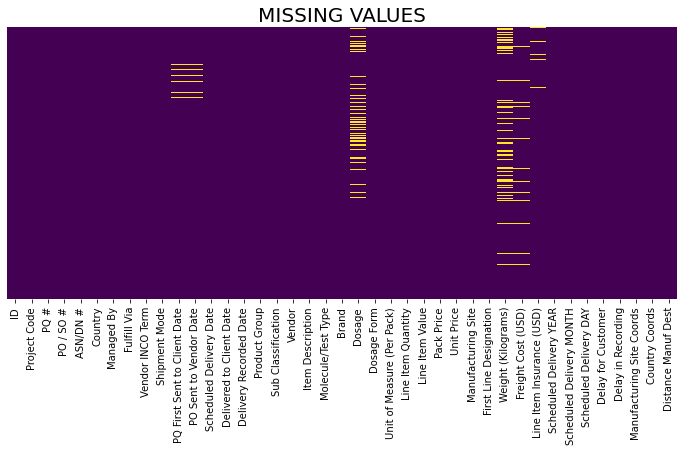

In [4]:
plt.figure(figsize = (12, 5))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = "viridis")
plt.title("MISSING VALUES", fontsize =20)

for x in df.columns:
    if df[x].isna().sum() > 0:
        print("{} : {}  |  {:.2f} %".format(x, df[x].isna().sum(),
                                            df[x].isna().sum()/len(df)*100 ))             

## PRICE PREDICTION

In [76]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

XY = preparation.preprocessing_for_ml(df)

# NEW ANALYSIS OF CORRELATIONS
plt.figure(figsize = (18, 8))
sns.heatmap(preparation.preprocessing_for_ml(df).corr(),
            annot = True, cbar = False,
            vmin = -1, vmax = 1, cmap = "RdBu_r")
plt.show()

In [77]:
X = XY.drop("Unit Price", axis = 1).copy()
y = np.log(XY["Unit Price"] + 0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, random_state = 42)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [89]:
from sklearn.linear_model import LassoCV

lr = LassoCV(n_jobs = -1, random_state = 42)
lr.fit(X_train, y_train)

print(f"R^2: {r2_score(y_test, lr.predict(X_test)):.3f}")
print("MAPE: {:.2f} USD".format(mean_absolute_percentage_error(np.exp(y_test),
                                                               np.exp(lr.predict(X_test)))))

R^2: 0.669
MAPE: 0.70 USD


In [91]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(random_state = 42, criterion = "squared_error")
tree.fit(X_train, y_train)

ccp_path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

# Tree Pruning (we are overfitting - Accuracy: 100% in training)
tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                            for impty in np.linspace(max(0.1, impurities.min() + 0.01),
                                                     np.round(impurities.max()/2, 3),
                                                     num = 10)]}
tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 42,
                                               criterion = "squared_error"),
                         tree_params, cv = 3, n_jobs = 6, verbose = 10,
                         return_train_score = True)
tree_grid.fit(X_train, y_train)

forest = GradientBoostingRegressor(n_estimators = 50, loss = "squared_error",
                                   random_state = 42,
                                   ccp_alpha = tree_grid.best_estimator_.ccp_alpha)
forest.fit(X_train, y_train)

print(f"R^2: {r2_score(y_test, forest.predict(X_test)):.3f}")
print("MAPE: {:.2f} USD".format(mean_absolute_percentage_error(np.exp(y_test),
                                                               np.exp(forest.predict(X_test)))))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
R^2: 0.962
MAPE: 0.16 USD
